In [79]:
import sys
import os
from enum import Enum

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu
from sklearn.feature_selection import mutual_info_classif

In [80]:
sys.path.append(os.path.abspath('..'))
from src.data_loader import load_data
from src.config import (
    RANDOM_SEED, FIGURES_DIR, RESULTS_DIR,
    NUMERICAL_FEATURES, CATEGORICAL_FEATURES, ORDINAL_FEATURES,
    TARGET_FEATURE, ALL_FEATURES,
    Color
)

In [3]:
np.random.seed(RANDOM_SEED)

# vis config
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.1)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (10, 6)


In [4]:
train_df, test_df = load_data()

Loading training data from /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/data/train.parquet
Loading test data from /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/data/test.parquet
Train shape: (20000, 11)
Test shape: (5000, 11)


In [5]:
print(">>> TRAIN")
print(train_df.info())
print(f"Shape: {train_df.shape}")
print(f"Default rate: {train_df['Default'].value_counts(normalize=True)}")
print(f"Default rate in train: {train_df['Default'].mean():.2%}")
print(f"Missing values:\n{train_df.isnull().sum()}")

print("\n>>> TEST ")
print(test_df.info())
print(f"Shape: {test_df.shape}")
print(f"Has Default? {'Default' in test_df.columns}")
if 'Default' in test_df.columns:
    print(f"Default rate: {test_df['Default'].value_counts(normalize=True)}")
    print(f"Default rate in test: {test_df['Default'].mean():.2%}")

>>> TRAIN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              20000 non-null  int64  
 1   Income           20000 non-null  float64
 2   CreditScore      17617 non-null  float64
 3   LoanAmount       20000 non-null  float64
 4   EmploymentYears  20000 non-null  int64  
 5   NumDependents    20000 non-null  int64  
 6   DebtToIncome     20000 non-null  float64
 7   EducationLevel   20000 non-null  int64  
 8   FavoriteColor    20000 non-null  object 
 9   Hobby            20000 non-null  object 
 10  Default          20000 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 1.7+ MB
None
Shape: (20000, 11)
Default rate: Default
0    0.65685
1    0.34315
Name: proportion, dtype: float64
Default rate in train: 34.31%
Missing values:
Age                   0
Income                0
CreditScore        238

In [6]:
print("=" * 80)
print("DATA STRUCTURE")
print("=" * 80)

print(f"Total samples: {train_df.shape[0] + test_df.shape[0]:,}")

# verify both datasets have the same columns
train_cols = set(train_df.columns)
test_cols = set(test_df.columns)

assert(train_cols == test_cols)

print("\nColumn details:")
print(train_df.dtypes)

print(f"\nMemory usage:")
print(f"Training set: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Test set: {test_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

DATA STRUCTURE
Total samples: 25,000

Column details:
Age                  int64
Income             float64
CreditScore        float64
LoanAmount         float64
EmploymentYears      int64
NumDependents        int64
DebtToIncome       float64
EducationLevel       int64
FavoriteColor       object
Hobby               object
Default              int64
dtype: object

Memory usage:
Training set: 3.46 MB
Test set: 0.87 MB


In [7]:
print("=" * 80)
print("SAMPLE DATA")
print("=" * 80)

print("\nFirst 5 rows of training data:")
display(train_df.head())

print("\nFirst 5 rows of test data:")
display(test_df.head())

SAMPLE DATA

First 5 rows of training data:


,Age,Income,CreditScore,LoanAmount,EmploymentYears,NumDependents,DebtToIncome,EducationLevel,FavoriteColor,Hobby,Default
0,59,16785.977212,604.0,19416.230574,3,2,0.912395,3,Green,Traveling,0
1,49,62263.017648,613.0,16902.153253,33,2,0.455917,1,Blue,Traveling,0
2,35,62414.862646,NaN,21639.847552,1,1,0.817570,3,Blue,Traveling,0
3,63,62653.254368,363.0,17216.445061,3,0,0.519046,3,Green,Reading,1
4,28,54601.849437,607.0,22955.590991,22,4,0.197581,1,Yellow,Reading,0



First 5 rows of test data:


,Age,Income,CreditScore,LoanAmount,EmploymentYears,NumDependents,DebtToIncome,EducationLevel,FavoriteColor,Hobby,Default
20000,65,46268.170006,799.0,21006.486795,28,2,0.408134,4,Yellow,Sports,0
20001,60,53019.204347,532.0,16096.908958,13,0,0.689294,1,Blue,Sports,0
20002,68,36639.270263,490.0,21399.505528,18,0,0.440931,3,Blue,Reading,1
20003,44,32326.717615,726.0,23690.410875,6,0,0.981147,4,Red,Reading,0
20004,49,50226.966160,798.0,21018.127774,24,4,0.796241,1,Red,Sports,0


In [8]:
print("=" * 80)
print("DATA TYPE VALIDATION")
print("=" * 80)

print("\nExpected numerical features:")
for feat in NUMERICAL_FEATURES:
    dtype = train_df[feat].dtype
    print(f"  {feat}: {dtype}", end="")
    if dtype in ['int64', 'float64']:
        print(" OK")
    else:
        print(f" !! (expected numeric, got {dtype})")

print("\nExpected categorical features:")
for feat in CATEGORICAL_FEATURES:
    dtype = train_df[feat].dtype
    print(f"  {feat}: {dtype}", end="")
    if dtype in ['object', 'category']:
        print(" OK")
    else:
        print(f" !! (expected categorical, got {dtype})")

print("\nOrdinal feature:")
for feat in ORDINAL_FEATURES:
    dtype = train_df[feat].dtype
    print(f"  {feat}: {dtype}", end="")
    if dtype == 'int64':
        print(" OK")
    else:
        print(f" !! (expected int64, got {dtype})")

print("\nTarget variable:")
dtype = train_df[TARGET_FEATURE].dtype
print(f"  {TARGET_FEATURE}: {dtype}", end="")
if dtype in ['int64', 'int32']:
    print(" OK")
else:
    print(f" !! (expected int, got {dtype})")

DATA TYPE VALIDATION

Expected numerical features:
  Age: int64 OK
  Income: float64 OK
  CreditScore: float64 OK
  LoanAmount: float64 OK
  EmploymentYears: int64 OK
  NumDependents: int64 OK
  DebtToIncome: float64 OK

Expected categorical features:
  FavoriteColor: object OK
  Hobby: object OK

Ordinal feature:
  EducationLevel: int64 OK

Target variable:
  Default: int64 OK


TARGET VARIABLE DISTRIBUTION

Training set:
  Class 0 (Solvent): 13,137 (65.69%)
  Class 1 (Default): 6,863 (34.31%)

Test set:
  Class 0 (Solvent): 3,240 (64.80%)
  Class 1 (Default): 1,760 (35.20%)


Difference in default rate: 0.88 percentage points




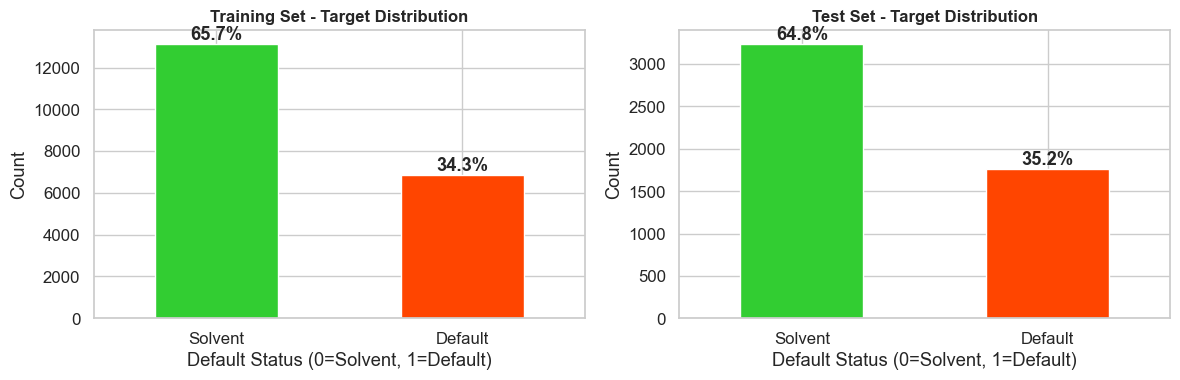


Figure saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/figures/01_target_distribution.png


In [9]:
print("=" * 80)
print("TARGET VARIABLE DISTRIBUTION")
print("=" * 80)

# calc distributions for both sets
train_target_dist = train_df[TARGET_FEATURE].value_counts().sort_index()
test_target_dist = test_df[TARGET_FEATURE].value_counts().sort_index()

train_target_pct = train_df[TARGET_FEATURE].value_counts(normalize=True).sort_index() * 100
test_target_pct = test_df[TARGET_FEATURE].value_counts(normalize=True).sort_index() * 100

print("\nTraining set:")
print(f"  Class 0 (Solvent): {train_target_dist[0]:,} ({train_target_pct[0]:.2f}%)")
print(f"  Class 1 (Default): {train_target_dist[1]:,} ({train_target_pct[1]:.2f}%)")

print("\nTest set:")
print(f"  Class 0 (Solvent): {test_target_dist[0]:,} ({test_target_pct[0]:.2f}%)")
print(f"  Class 1 (Default): {test_target_dist[1]:,} ({test_target_pct[1]:.2f}%)")

# check if dists are similar (proper train/test split)
diff = abs(train_target_pct[1] - test_target_pct[1])
print(f"\n\nDifference in default rate: {diff:.2f} percentage points")

# Visualize the distribution
print ("\n")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

colors = [Color.GREEN.value, Color.RED.value]

# Training set distribution
train_target_dist.plot(kind='bar', ax=ax1, color=colors)
ax1.set_title('Training Set - Target Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Default Status (0=Solvent, 1=Default)')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Solvent', 'Default'], rotation=0)
for i, v in enumerate(train_target_dist):
    ax1.text(i, v + 200, f'{train_target_pct[i]:.1f}%', ha='center', fontweight='bold')

# Test set distribution
test_target_dist.plot(kind='bar', ax=ax2, color=colors)
ax2.set_title('Test Set - Target Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Default Status (0=Solvent, 1=Default)')
ax2.set_ylabel('Count')
ax2.set_xticklabels(['Solvent', 'Default'], rotation=0)
for i, v in enumerate(test_target_dist):
    ax2.text(i, v + 50, f'{test_target_pct[i]:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / '01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to {FIGURES_DIR / '01_target_distribution.png'}")

In [11]:
print("=" * 80)
print("MISSING DATA")
print("=" * 80)

# Calculate missing value statistics for training set
train_missing = pd.DataFrame({
    'Feature': train_df.columns,
    'Missing_Count': train_df.isnull().sum(),
    'Missing_Percentage': (train_df.isnull().sum() / len(train_df) * 100).round(2)
})
# get only features (cols) where missing values are present
train_missing = train_missing[train_missing['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

# Calculate for test set
test_missing = pd.DataFrame({
    'Feature': test_df.columns,
    'Missing_Count': test_df.isnull().sum(),
    'Missing_Percentage': (test_df.isnull().sum() / len(test_df) * 100).round(2)
})
test_missing = test_missing[test_missing['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print("\nTraining Set Missing Values:")
if len(train_missing) == 0:
    print(">>  No missing values detected")
else:
    display(train_missing)

print("\nTest Set Missing Values:")
if len(test_missing) == 0:
    print(">>  No missing values detected")
else:
    display(test_missing)

# check if missing patterns are consistent between train and test
if len(train_missing) > 0 and len(test_missing) > 0:
    train_features_with_missing = set(train_missing['Feature'])
    test_features_with_missing = set(test_missing['Feature'])
    
    if train_features_with_missing == test_features_with_missing:
        print("\n>> Same features have missing values in both train and test")
    else:
        print("\n !! WARNING: Different features have missing values in train vs test")
        print(f"  Only in train: {train_features_with_missing - test_features_with_missing}")
        print(f"  Only in test: {test_features_with_missing - train_features_with_missing}")

MISSING DATA

Training Set Missing Values:


,Feature,Missing_Count,Missing_Percentage
CreditScore,CreditScore,2383,11.92



Test Set Missing Values:


,Feature,Missing_Count,Missing_Percentage
CreditScore,CreditScore,608,12.16



>> Same features have missing values in both train and test


In [12]:
print("=" * 80)
print("CREDITSCCORE MISSINGNESS vs DEFAULT RATE")
print("=" * 80)

# create a missingness indicator
train_df['CreditScore_Missing'] = train_df['CreditScore'].isnull()

# calculate default rates for each group (clients w/ and w/o missing CreditScore)
missing_stats = train_df.groupby('CreditScore_Missing')[TARGET_FEATURE].agg([
    ('Count', 'count'),
    ('Defaults', 'sum'),
    ('Default_Rate', 'mean')
]).round(4)

missing_stats['Default_Rate_Pct'] = (missing_stats['Default_Rate'] * 100).round(2)

display(missing_stats)

print("\nDefault rates by CreditScore presence:")
print(f"\nCreditScore PRESENT:")
print(f"  Total customers: {missing_stats.loc[False, 'Count']:,}")
print(f"  Defaults: {int(missing_stats.loc[False, 'Defaults']):,}")
print(f"  Default rate: {missing_stats.loc[False, 'Default_Rate_Pct']:.2f}%")

print(f"\nCreditScore MISSING:")
print(f"  Total customers: {missing_stats.loc[True, 'Count']:,}")
print(f"  Defaults: {int(missing_stats.loc[True, 'Defaults']):,}")
print(f"  Default rate: {missing_stats.loc[True, 'Default_Rate_Pct']:.2f}%")

# calc the difference
rate_diff = missing_stats.loc[True, 'Default_Rate_Pct'] - missing_stats.loc[False, 'Default_Rate_Pct']
print(f"\nDifference in default rate: {rate_diff:+.2f} percentage points")

# chi-square test (of indpenedence) to see if the difference is statistically significant
contingency_table = pd.crosstab(train_df['CreditScore_Missing'], train_df[TARGET_FEATURE])
display(contingency_table)
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\n" + "=" * 80)
print("STATISTICAL SIGNIFICANCE TEST")
print("=" * 80)
print(f"\nChi-square test results:")
print(f"  X_2 statistic: {chi2:.4f}")
print(f"  p-value: {p_value:.6f}")
print(f"  Degrees of freedom: {dof}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print(f"\n!! SIGNIFICANT: Missingness is NOT random (p < {alpha})")
    print(f"The fact that CreditScore is missing carries information about default risk.")
else:
    print(f"\nNOT significant: Missingness appears random (p >= {alpha})")
    print(f"Simple imputation with median should be sufficient")

# Clean up the temporary column
train_df.drop('CreditScore_Missing', axis=1, inplace=True)

CREDITSCCORE MISSINGNESS vs DEFAULT RATE


,Count,Defaults,Default_Rate,Default_Rate_Pct
CreditScore_Missing,,,,
False,17617,6011,0.3412,34.12
True,2383,852,0.3575,35.75



Default rates by CreditScore presence:

CreditScore PRESENT:
  Total customers: 17,617
  Defaults: 6,011
  Default rate: 34.12%

CreditScore MISSING:
  Total customers: 2,383
  Defaults: 852
  Default rate: 35.75%

Difference in default rate: +1.63 percentage points


Default,0,1
CreditScore_Missing,,
False,11606,6011
True,1531,852



STATISTICAL SIGNIFICANCE TEST

Chi-square test results:
  X_2 statistic: 2.4109
  p-value: 0.120494
  Degrees of freedom: 1

NOT significant: Missingness appears random (p >= 0.05)
Simple imputation with median should be sufficient


,Total,Defaults,Default_Rate
CreditScore_Missing,,,
False,17617,6011,34.120452
True,2383,852,35.753252


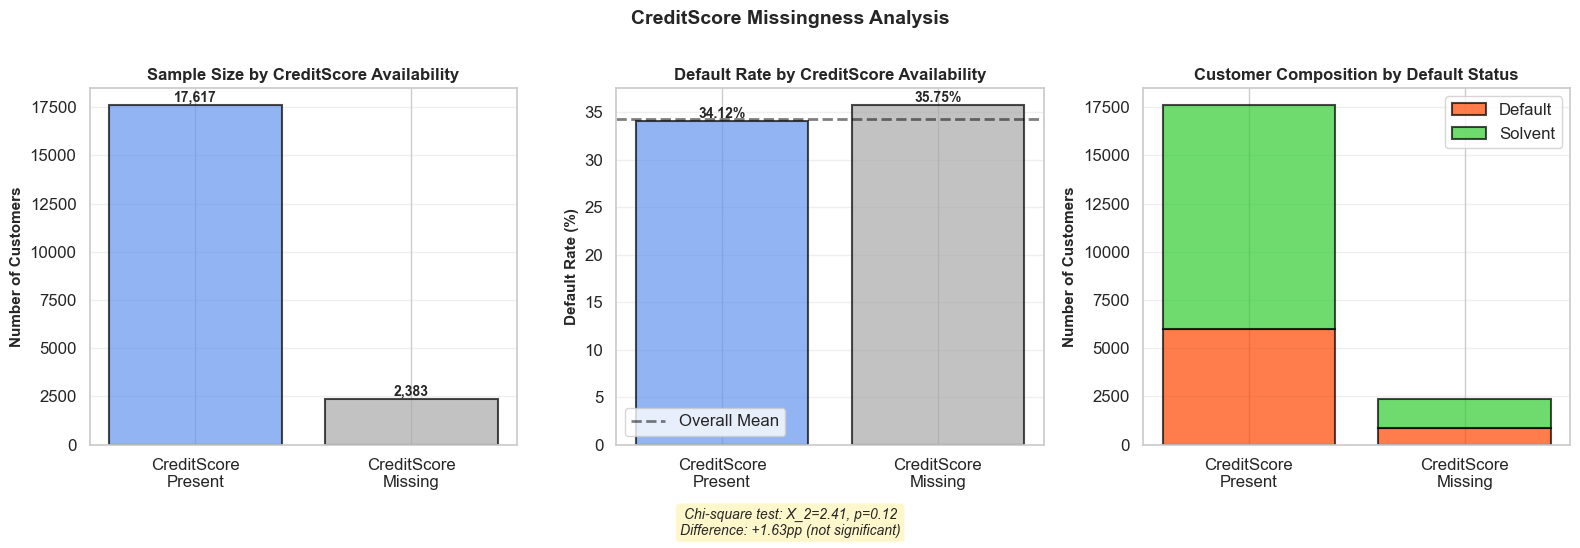


Figure saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/figures/02_missing_data_analysis.png


In [28]:
# visualize the missing data patterns

# this is temporary
train_df['CreditScore_Missing'] = train_df['CreditScore'].isnull()

# calc the statistics to vis just as previously
missing_groups = train_df.groupby('CreditScore_Missing')[TARGET_FEATURE].agg([
    ('Total', 'count'),
    ('Defaults', 'sum')
])
missing_groups['Default_Rate'] = (missing_groups['Defaults'] / missing_groups['Total'] * 100)

display(missing_groups)


# vis with 3 panels
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# panel 1: count of customers by missingness status
ax1 = axes[0]
colors_panel1 = [Color.BLUE.value, Color.GRAY.value]  # blue for present, gray for missing
bars1 = ax1.bar(['CreditScore\nPresent', 'CreditScore\nMissing'], 
                missing_groups['Total'], 
                color=colors_panel1, alpha=0.7, edgecolor=Color.BLACK.value, linewidth=1.5)
ax1.set_ylabel('Number of Customers', fontsize=11, fontweight='bold')
ax1.set_title('Sample Size by CreditScore Availability', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for i, (bar, value) in enumerate(zip(bars1, missing_groups['Total'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(value):,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Panel 2: default rate comparison
ax2 = axes[1]
bars2 = ax2.bar(['CreditScore\nPresent', 'CreditScore\nMissing'], 
                missing_groups['Default_Rate'],
                color=colors_panel1, alpha=0.7, edgecolor=Color.BLACK.value, linewidth=1.5)
ax2.set_ylabel('Default Rate (%)', fontsize=11, fontweight='bold')
ax2.set_title('Default Rate by CreditScore Availability', fontsize=12, fontweight='bold')
ax2.axhline(y=train_df[TARGET_FEATURE].mean() * 100, color=Color.BLACK.value, 
            linestyle='--', linewidth=2, label='Overall Mean', alpha=0.5)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

for i, (bar, value) in enumerate(zip(bars2, missing_groups['Default_Rate'])):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.2f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Panel 3: stacked
ax3 = axes[2]
present_defaults = missing_groups.loc[False, 'Defaults']
present_solvent = missing_groups.loc[False, 'Total'] - present_defaults
missing_defaults = missing_groups.loc[True, 'Defaults']
missing_solvent = missing_groups.loc[True, 'Total'] - missing_defaults

x = ['CreditScore\nPresent', 'CreditScore\nMissing']
width = .8

# colors: green for solvent (good), red for default (bad)
ax3.bar(x, [present_defaults, missing_defaults], width, 
        label='Default', color=Color.RED.value, alpha=0.7, 
        edgecolor=Color.BLACK.value, linewidth=1.5)
ax3.bar(x, [present_solvent, missing_solvent], width, 
        bottom=[present_defaults, missing_defaults],
        label='Solvent', color=Color.GREEN.value, alpha=0.7, 
        edgecolor=Color.BLACK.value, linewidth=1.5)

ax3.set_ylabel('Number of Customers', fontsize=11, fontweight='bold')
ax3.set_title('Customer Composition by Default Status', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# statistical test result annotation
textstr = f'Chi-square test: X_2=2.41, p=0.12\nDifference: +1.63pp (not significant)'
props = dict(boxstyle='round', facecolor=Color.YELLOW.value, alpha=0.2)
fig.text(0.5, -0.05, textstr, ha='center', fontsize=10, 
         bbox=props, style='italic')

plt.suptitle('CreditScore Missingness Analysis', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '02_missing_data_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# clear
train_df.drop('CreditScore_Missing', axis=1, inplace=True)

print(f"\nFigure saved to {FIGURES_DIR / '02_missing_data_analysis.png'}")

In [36]:
print("=" * 80)
print("NUMERICAL FEATURES - BASIC SUMMARY STATISTICS")
print("=" * 80)

# summary stats for train set
train_summary = train_df[NUMERICAL_FEATURES].describe()
print("\nTraining Set:")
display(train_summary)

# summary stats for test set
test_summary = test_df[NUMERICAL_FEATURES].describe()
print("\nTest Set:")
display(test_summary)

# check for any major differences between train and test
print("\n" + "=" * 80)
print("TRAIN vs TEST DISTRIBUTION COMPARISON")
print("=" * 80)

# Compare means
mean_diff = ((test_summary.loc['mean'] - train_summary.loc['mean']) / train_summary.loc['mean'] * 100)
print("\nPercentage difference in means (Test vs Train):")
for feature in NUMERICAL_FEATURES:
    diff = mean_diff[feature]
    status = "OK" if abs(diff) < 5 else "!!" # <5% diff seems reasonable
    print(f"  {feature:20s}: {diff:+6.2f}% {status}")

NUMERICAL FEATURES - BASIC SUMMARY STATISTICS

Training Set:


,Age,Income,CreditScore,LoanAmount,EmploymentYears,NumDependents,DebtToIncome
count,20000.000000,20000.000000,17617.000000,20000.000000,20000.000000,20000.00000,20000.000000
mean,44.959150,50008.728050,574.118635,20030.838112,19.369250,1.98985,0.502592
std,14.083764,15004.975929,159.041321,4990.813958,11.548159,1.41193,0.289153
min,21.000000,23.390659,300.000000,299.958110,0.000000,0.00000,0.000018
25%,33.000000,39716.883271,437.000000,16646.478319,9.000000,1.00000,0.251572
50%,45.000000,50084.103696,575.000000,20046.233086,19.000000,2.00000,0.501503
75%,57.000000,60285.318369,711.000000,23393.056940,29.000000,3.00000,0.753517
max,69.000000,117186.263765,849.000000,38800.776243,39.000000,4.00000,0.999984



Test Set:


,Age,Income,CreditScore,LoanAmount,EmploymentYears,NumDependents,DebtToIncome
count,5000.000000,5000.000000,4392.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,44.932800,49713.369892,569.282559,19985.813991,19.603200,1.999200,0.511993
std,14.281396,15000.114910,159.305492,5069.524268,11.465463,1.410956,0.287230
min,21.000000,517.085994,300.000000,4084.783672,0.000000,0.000000,0.000011
25%,33.000000,39364.243116,432.000000,16540.195620,10.000000,1.000000,0.269261
50%,45.000000,49769.864008,562.000000,20008.658037,19.500000,2.000000,0.519398
75%,57.000000,59943.586025,708.000000,23425.483395,30.000000,3.000000,0.761215
max,69.000000,105917.500171,849.000000,38027.953418,39.000000,4.000000,0.999928



TRAIN vs TEST DISTRIBUTION COMPARISON

Percentage difference in means (Test vs Train):
  Age                 :  -0.06% OK
  Income              :  -0.59% OK
  CreditScore         :  -0.84% OK
  LoanAmount          :  -0.22% OK
  EmploymentYears     :  +1.21% OK
  NumDependents       :  +0.47% OK
  DebtToIncome        :  +1.87% OK


In [37]:
print("=" * 80)
print("DATA QUALITY CHECK: INVESTIGATING IMPOSSIBLE VALUES")
print("=" * 80)

# Check for negative values in features that should always be positive
features_to_check = ['Income', 'LoanAmount']

for feature in features_to_check:
    print(f"\n{feature}:")
    print("-" * 40)
    
    # train
    train_negative = train_df[train_df[feature] < 0]
    display(train_negative)
    train_negative_count = len(train_negative)
    train_negative_pct = (train_negative_count / len(train_df)) * 100
    
    print(f"Training set:")
    print(f"  Negative values: {train_negative_count:,} ({train_negative_pct:.2f}%)")
    if train_negative_count > 0:
        print(f"  Min value: {train_df[feature].min():,.2f}")
        print(f"  Default rate for negative values: {train_negative[TARGET_FEATURE].mean()*100:.2f}%")
    
    # test
    test_negative = test_df[test_df[feature] < 0]
    display(test_negative)
    test_negative_count = len(test_negative)
    test_negative_pct = (test_negative_count / len(test_df)) * 100
    
    print(f"Test set:")
    print(f"  Negative values: {test_negative_count:,} ({test_negative_pct:.2f}%)")
    if test_negative_count > 0:
        print(f"  Min value: {test_df[feature].min():,.2f}")
        print(f"  Default rate for negative values: {test_negative[TARGET_FEATURE].mean()*100:.2f}%")

# check if these negative values appear together
print("\n" + "=" * 80)
print("PATTERN ANALYSIS: Do customers have multiple negative values?")
print("=" * 80)

train_df['has_negative_income'] = train_df['Income'] < 0
train_df['has_negative_loan'] = train_df['LoanAmount'] < 0

overlap = train_df[train_df['has_negative_income'] & train_df['has_negative_loan']]
print(f"\nCustomers with BOTH negative Income AND negative LoanAmount: {len(overlap):,}")

if len(overlap) > 0:
    print("!! Prob. a systematic data issue, not random errors")
else:
    print("Negative values don't cluster - likely independent data entry errors")

# clean up
train_df.drop(['has_negative_income', 'has_negative_loan'], axis=1, inplace=True)

DATA QUALITY CHECK: INVESTIGATING IMPOSSIBLE VALUES

Income:
----------------------------------------


,Age,Income,CreditScore,LoanAmount,EmploymentYears,NumDependents,DebtToIncome,EducationLevel,FavoriteColor,Hobby,Default


Training set:
  Negative values: 0 (0.00%)


,Age,Income,CreditScore,LoanAmount,EmploymentYears,NumDependents,DebtToIncome,EducationLevel,FavoriteColor,Hobby,Default


Test set:
  Negative values: 0 (0.00%)

LoanAmount:
----------------------------------------


,Age,Income,CreditScore,LoanAmount,EmploymentYears,NumDependents,DebtToIncome,EducationLevel,FavoriteColor,Hobby,Default


Training set:
  Negative values: 0 (0.00%)


,Age,Income,CreditScore,LoanAmount,EmploymentYears,NumDependents,DebtToIncome,EducationLevel,FavoriteColor,Hobby,Default


Test set:
  Negative values: 0 (0.00%)

PATTERN ANALYSIS: Do customers have multiple negative values?

Customers with BOTH negative Income AND negative LoanAmount: 0
Negative values don't cluster - likely independent data entry errors


In [34]:
print("=" * 80)
print("DATA CLEANING: CORRECTING SIGN ERRORS")
print("=" * 80)

# the decision
print("\nDecision: Negative values in Income and LoanAmount appear to be data entry errors (accidental negative signs). Correcting by taking absolute values.")
print("\nAffected records:")

features_to_fix = ['Income', 'LoanAmount']
changes_made = {}

for feature in features_to_fix:
    # train
    train_negative_mask = train_df[feature] < 0
    train_count = train_negative_mask.sum()
    
    if train_count > 0:
        print(f"\n{feature} (Training set): {train_count} records")
        print(f"  Before: min = {train_df[feature].min():.2f}")
        train_df.loc[train_negative_mask, feature] = train_df.loc[train_negative_mask, feature].abs()
        print(f"  After:  min = {train_df[feature].min():.2f}")
    
    # test
    test_negative_mask = test_df[feature] < 0
    test_count = test_negative_mask.sum()
    
    if test_count > 0:
        print(f"\n{feature} (Test set): {test_count} records")
        print(f"  Before: min = {test_df[feature].min():.2f}")
        test_df.loc[test_negative_mask, feature] = test_df.loc[test_negative_mask, feature].abs()
        print(f"  After:  min = {test_df[feature].min():.2f}")
    
    changes_made[feature] = {'train': train_count, 'test': test_count}

print("\n" + "=" * 80)
print("VERIFICATION: Checking for remaining negative values")
print("=" * 80)

all_clean = True
for feature in features_to_fix:
    train_neg = (train_df[feature] < 0).sum()
    test_neg = (test_df[feature] < 0).sum()
    
    if train_neg == 0 and test_neg == 0:
        print(f"OK {feature}: No negative values remaining")
    else:
        print(f"!! {feature}: Still has negative values (train: {train_neg}, test: {test_neg})")
        all_clean = False

if all_clean:
    print("\nAll sign errors corrected successfully")
else:
    print("\n!! Warning: Some negative values remain - investigate further")

DATA CLEANING: CORRECTING SIGN ERRORS

Decision: Negative values in Income and LoanAmount appear to be data entry errors (accidental negative signs). Correcting by taking absolute values.

Affected records:

Income (Training set): 11 records
  Before: min = -16984.06
  After:  min = 23.39

Income (Test set): 2 records
  Before: min = -1540.94
  After:  min = 517.09

LoanAmount (Training set): 2 records
  Before: min = -2314.84
  After:  min = 299.96

VERIFICATION: Checking for remaining negative values
OK Income: No negative values remaining
OK LoanAmount: No negative values remaining

All sign errors corrected successfully


In [42]:
print("=" * 80)
print("NUMERICAL FEATURES BY DEFAULT STATUS")
print("=" * 80)

# calc summary statistics grouped by Default status
default_comparison = train_df.groupby(TARGET_FEATURE)[NUMERICAL_FEATURES].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('25%', lambda x: x.quantile(0.25)),
    ('50%', lambda x: x.quantile(0.50)),
    ('75%', lambda x: x.quantile(0.75)),
    ('max', 'max')
]).round(2)

print("\nSummary Statistics by Default Status:")
print("(0 = Solvent, 1 = Default)")
display(default_comparison.T)

# clca the difference in means between binary outcomes
print("\n" + "=" * 80)
print("MEAN DIFFERENCES: Default vs Solvent")
print("=" * 80)

means_by_default = train_df.groupby(TARGET_FEATURE)[NUMERICAL_FEATURES].mean()
mean_differences = means_by_default.loc[1] - means_by_default.loc[0]
pct_differences = (mean_differences / means_by_default.loc[0] * 100).round(2)

print("\nAbsolute and percentage differences in means:")
print(f"{'Feature':<20} {'Solvent Mean':>15} {'Default Mean':>15} {'Difference':>15} {'% Diff':>10}")
print("-" * 80)

for feature in NUMERICAL_FEATURES:
    solvent_mean = means_by_default.loc[0, feature]
    default_mean = means_by_default.loc[1, feature]
    diff = mean_differences[feature]
    pct_diff = pct_differences[feature]
    
    print(f"{feature:<20} {solvent_mean:>15.2f} {default_mean:>15.2f} {diff:>15.2f} {pct_diff:>9.2f}%")

# identify features with largest separation
print("\n" + "=" * 80)
print("FEATURES RANKED BY SEPARATION")
print("=" * 80)

# Use absolute percentage difference as a measure of separation
separation_ranking = pct_differences.abs().sort_values(ascending=False)

print("\nFeatures ranked by percentage difference in means:")
print(f"{'Rank':<6} {'Feature':<20} {'% Difference':>15} {'Direction':>12}")
print("-" * 60)

for i, (feature, pct_diff) in enumerate(separation_ranking.items(), 1):
    abs_diff = mean_differences[feature]
    direction = "Higher" if abs_diff > 0 else "Lower"
    print(f"{i:<6} {feature:<20} {pct_diff:>14.2f}% {direction:>15}")

print("\nDirection indicates whether defaulters have higher or lower values compared to solvent customers.")


NUMERICAL FEATURES BY DEFAULT STATUS

Summary Statistics by Default Status:
(0 = Solvent, 1 = Default)


Default                        0          1
Age             count   13137.00    6863.00
                mean       46.35      42.30
                std        13.49      14.80
                min        21.00      21.00
                25%        35.00      28.00
                50%        46.00      41.00
                75%        58.00      55.00
                max        69.00      69.00
Income          count   13137.00    6863.00
                mean    51449.66   47250.52
                std     14506.49   15548.63
                min        23.39      57.44
                25%     42196.77   36084.88
                50%     51281.58   46687.48
                75%     61120.61   58374.93
                max    117186.26  105374.37
CreditScore     count   11606.00    6011.00
                mean      615.49     494.24
                std       155.70     132.83
                min       300.00     300.00
                25%       489.00     389.00
                50%       642.00     478.00
                75%       746.00     571.00
                max       849.00     849.00
LoanAmount      count   13137.00    6863.00
                mean    19786.77   20498.03
                std      4869.10    5184.28
                min       299.96     788.67
                25%     16520.68   16922.70
                50%     19856.44   20415.64
                75%     23056.88   24198.67
                max     38800.78   37680.24
EmploymentYears count   13137.00    6863.00
                mean       19.51      19.11
                std        11.52      11.60
                min         0.00       0.00
                25%        10.00       9.00
                50%        19.00      19.00
                75%        30.00      29.00
                max        39.00      39.00
NumDependents   count   13137.00    6863.00
                mean        1.99       1.99
                std         1.41       1.41
                min         0.00       0.00
                25%         1.00       1.00
                50%         2.00       2.00
                75%         3.00       3.00
                max         4.00       4.00
DebtToIncome    count   13137.00    6863.00
                mean        0.50       0.50
                std         0.29       0.29
                min         0.00       0.00
                25%         0.25       0.25
                50%         0.50       0.51
                75%         0.75       0.75
                max         1.00       1.00


MEAN DIFFERENCES: Default vs Solvent

Absolute and percentage differences in means:
Feature                 Solvent Mean    Default Mean      Difference     % Diff
--------------------------------------------------------------------------------
Age                            46.35           42.30           -4.04     -8.72%
Income                      51449.66        47250.52        -4199.14     -8.16%
CreditScore                   615.49          494.24         -121.25    -19.70%
LoanAmount                  19786.77        20498.03          711.27      3.59%
EmploymentYears                19.51           19.11           -0.40     -2.06%
NumDependents                   1.99            1.99           -0.00     -0.07%
DebtToIncome                    0.50            0.50            0.00      0.11%

FEATURES RANKED BY SEPARATION

Features ranked by percentage difference in means:
Rank   Feature                 % Difference    Direction
------------------------------------------------------

In [43]:
# save the comparison statistics to CSV
comparison_df = pd.DataFrame({
    'Feature': NUMERICAL_FEATURES,
    'Solvent_Mean': means_by_default.loc[0].values,
    'Default_Mean': means_by_default.loc[1].values,
    'Absolute_Difference': mean_differences.values,
    'Percentage_Difference': pct_differences.values
}).sort_values('Percentage_Difference', key=abs, ascending=False)

output_path = RESULTS_DIR / 'eda_summary_statistics.csv'
comparison_df.to_csv(output_path, index=False)

print(f"Comparison statistics saved to {output_path}")

Comparison statistics saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/results/eda_summary_statistics.csv


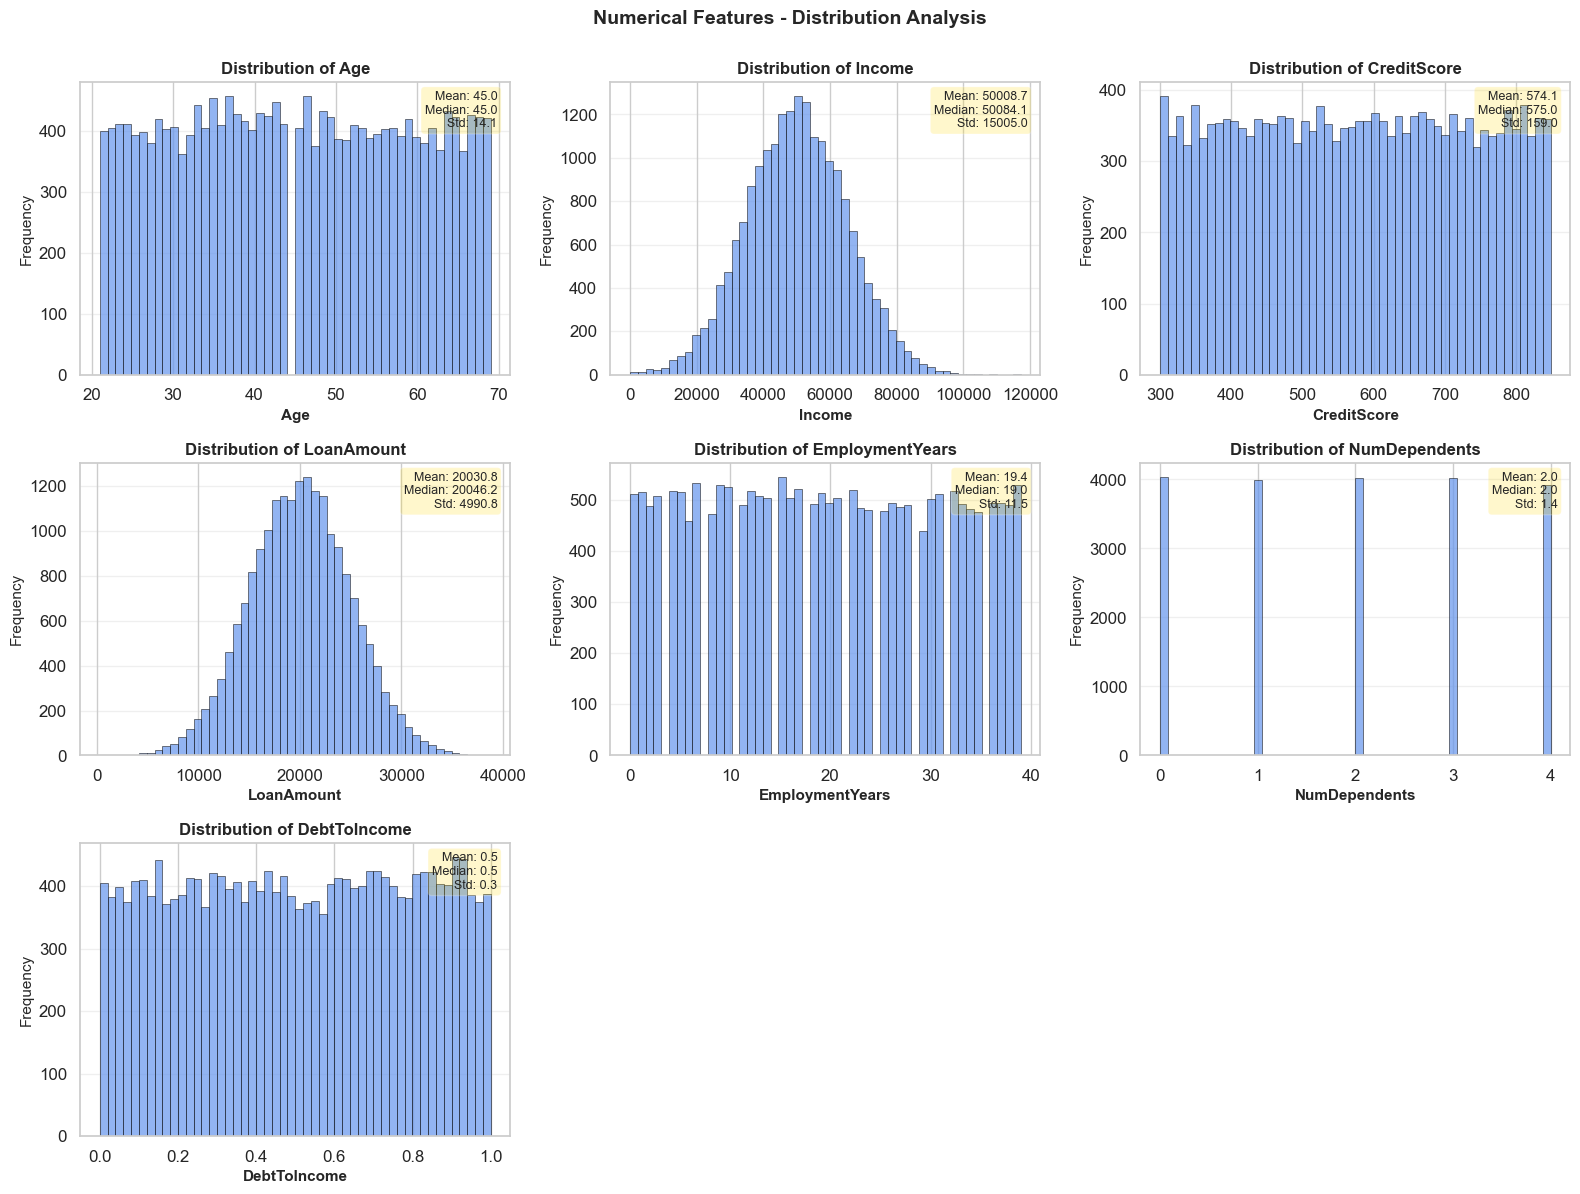

Figure saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/figures/03_numerical_distributions.png


In [45]:
print("=" * 80)
print("UNIVARIATE ANALYSIS: feature distributions")
print("=" * 80)

fig = plt.figure(figsize=(16, 12))

# Create subplots for each numerical feature
for idx, feature in enumerate(NUMERICAL_FEATURES, 1):
    ax = plt.subplot(3, 3, idx)
    
    # Pandas histogram - much simpler!
    train_df[feature].hist(bins=50, ax=ax, color=Color.BLUE.value, 
                           alpha=0.7, edgecolor=Color.BLACK.value, linewidth=0.5)
    
    # Calculate statistics
    data = train_df[feature].dropna()
    stats_text = f'Mean: {data.mean():.1f}\nMedian: {data.median():.1f}\nStd: {data.std():.1f}'
    
    ax.text(0.97, 0.97, stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor=Color.YELLOW.value, alpha=0.2),
            fontsize=9)
    
    ax.set_xlabel(feature, fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Numerical Features - Distribution Analysis', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '03_numerical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to {FIGURES_DIR / '03_numerical_distributions.png'}")

In [54]:
np.sort(train_df['Age'].unique())

array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69])

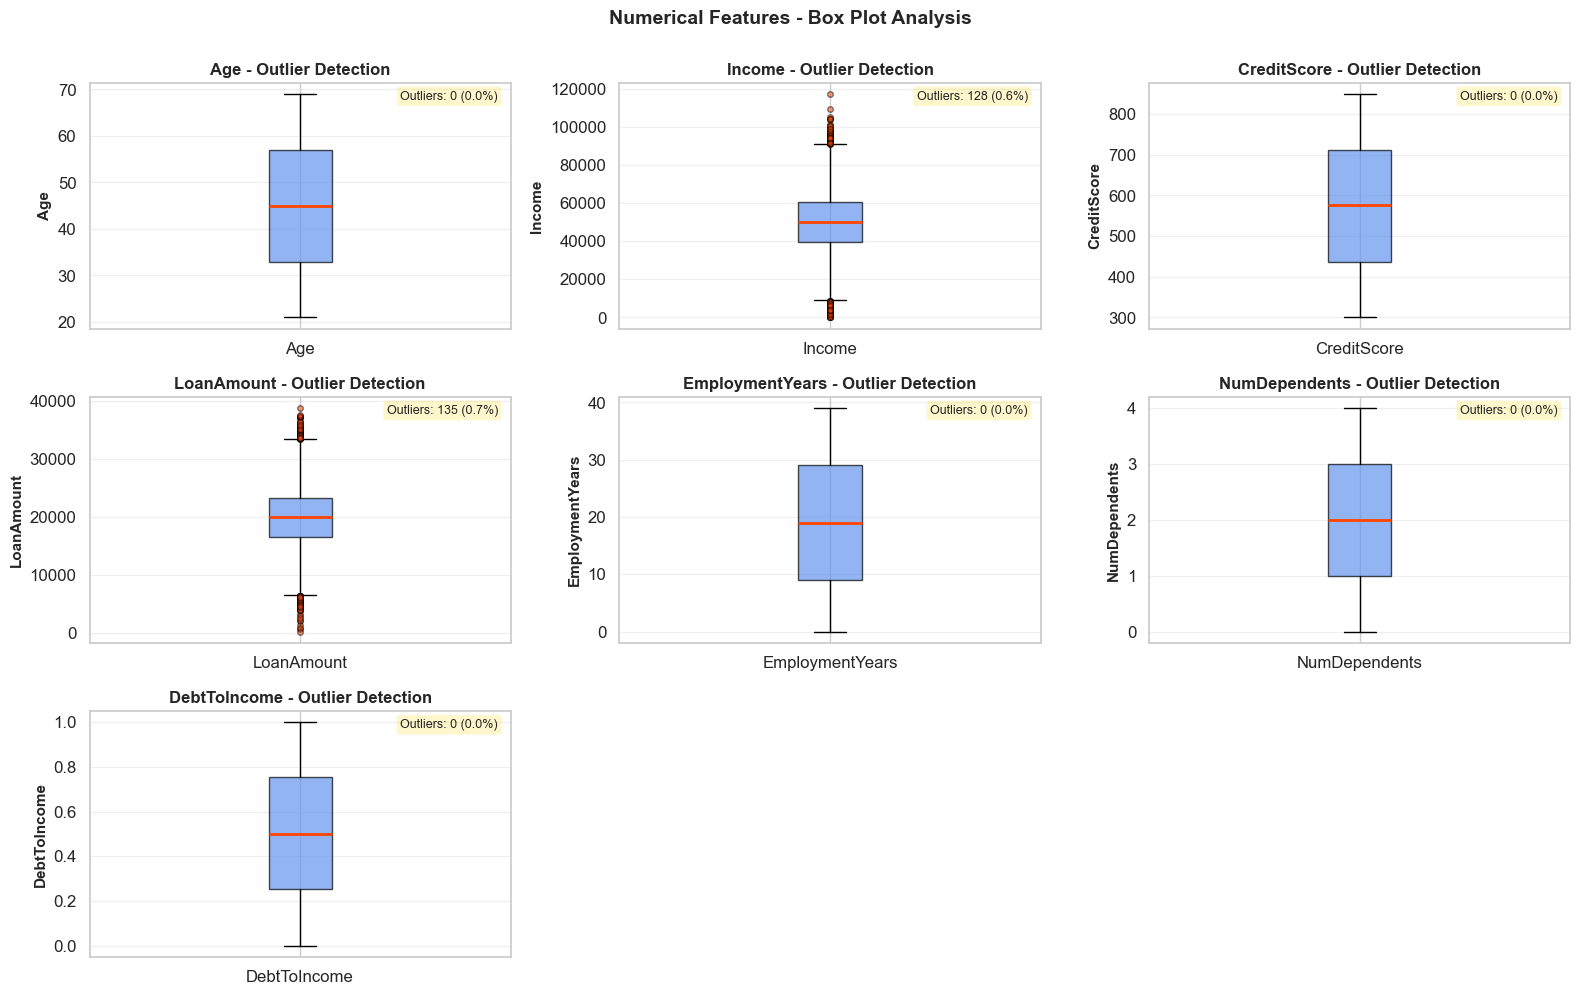

Figure saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/figures/04_numerical_boxplots.png


In [56]:
# box plot grid to identify outliers
fig = plt.figure(figsize=(16, 10))

for idx, feature in enumerate(NUMERICAL_FEATURES, 1):
    ax = plt.subplot(3, 3, idx)
    
    # Pandas box plot
    train_df.boxplot(column=feature, ax=ax, 
                     patch_artist=True,
                     boxprops=dict(facecolor=Color.BLUE.value, alpha=0.7),
                     medianprops=dict(color=Color.RED.value, linewidth=2),
                     whiskerprops=dict(color=Color.BLACK.value),
                     capprops=dict(color=Color.BLACK.value),
                     flierprops=dict(marker='o', markerfacecolor=Color.RED.value, 
                                   markersize=4, alpha=0.5))
    
    # calc outlier statistics using IQR method
    data = train_df[feature].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outlier_pct = (len(outliers) / len(data)) * 100
    
    stats_text = f'Outliers: {len(outliers)} ({outlier_pct:.1f}%)'
    ax.text(0.97, 0.97, stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor=Color.YELLOW.value, alpha=0.2),
            fontsize=9)
    
    ax.set_ylabel(feature, fontsize=11, fontweight='bold')
    ax.set_title(f'{feature} - Outlier Detection', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Numerical Features - Box Plot Analysis', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '04_numerical_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to {FIGURES_DIR / '04_numerical_boxplots.png'}")

BIVARIATE ANALYSIS: features vs default status


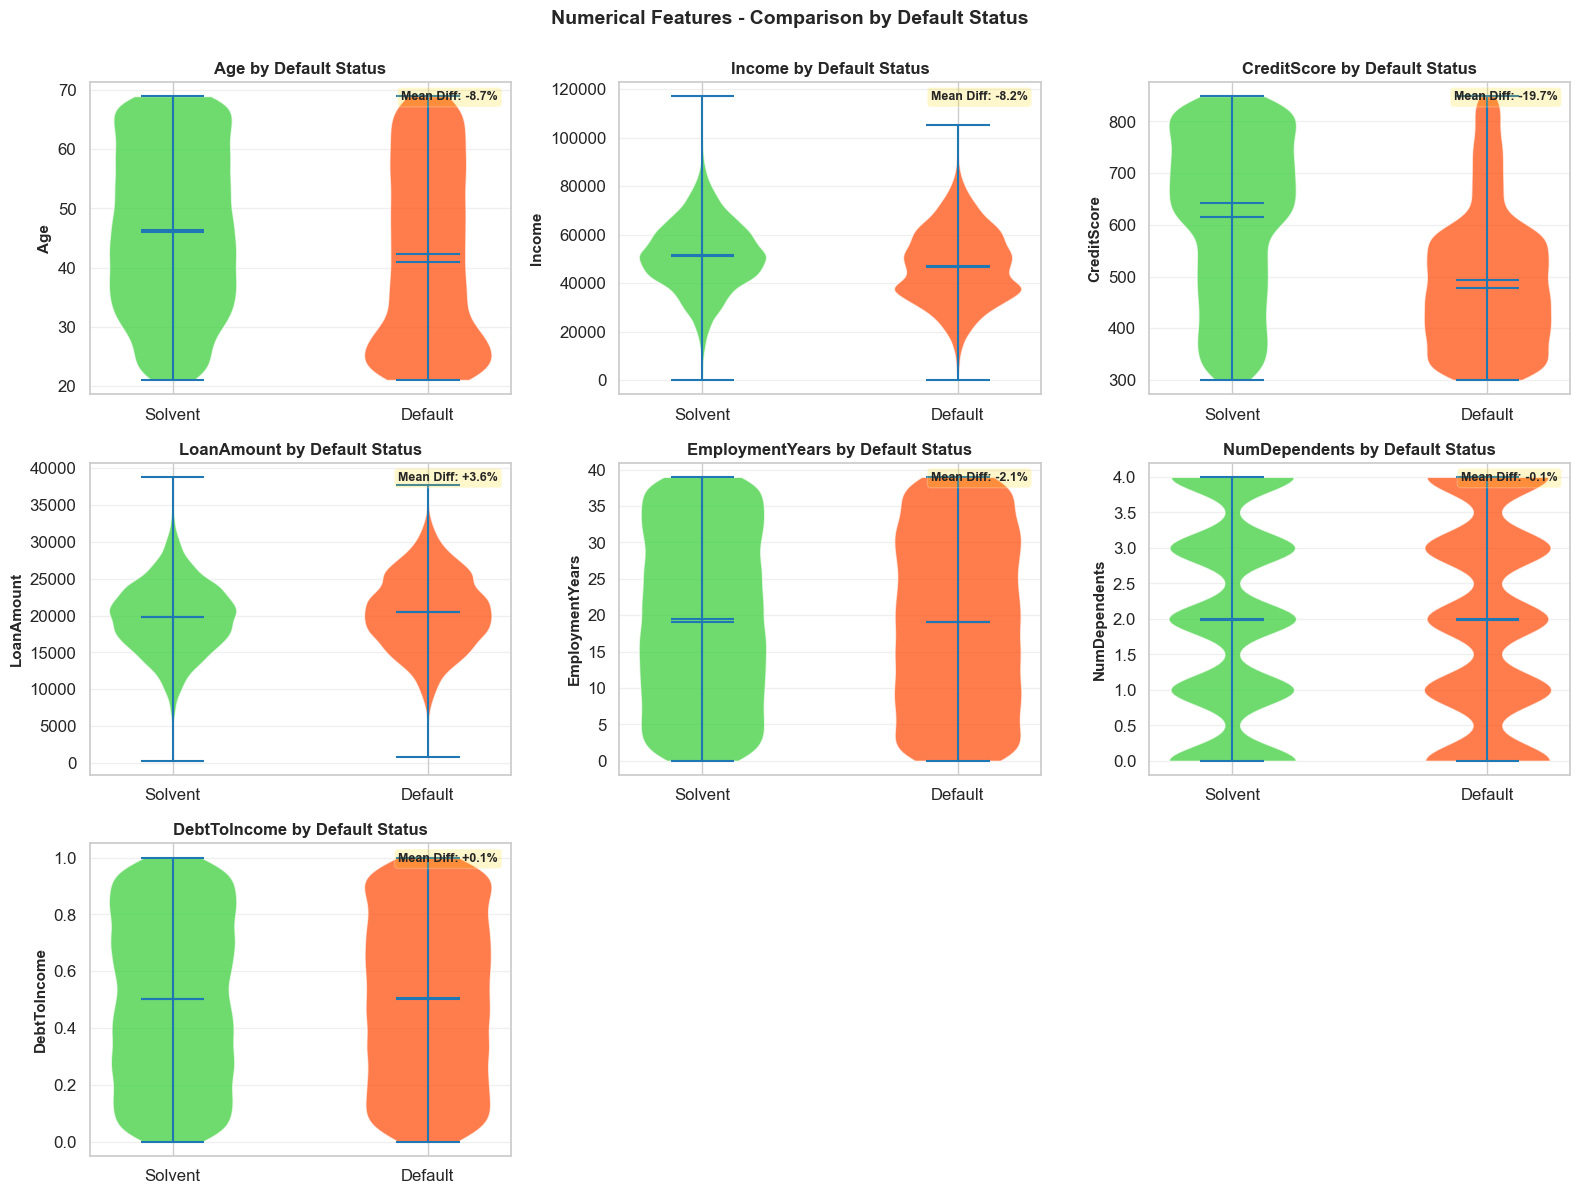

Figure saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/figures/06_features_by_default.png


In [58]:
print("=" * 80)
print("BIVARIATE ANALYSIS: features vs default status")
print("=" * 80)

#  violin plots to compare distributions by default status
fig = plt.figure(figsize=(16, 12))

for idx, feature in enumerate(NUMERICAL_FEATURES, 1):
    ax = plt.subplot(3, 3, idx)
    
    # prepare data for violin plot
    data_to_plot = [
        train_df[train_df[TARGET_FEATURE] == 0][feature].dropna(),
        train_df[train_df[TARGET_FEATURE] == 1][feature].dropna()
    ]
    
    # create violin plot
    parts = ax.violinplot(data_to_plot, positions=[0, 1], showmeans=True, showmedians=True)
    
    # Color the violins
    for i, pc in enumerate(parts['bodies']):
        if i == 0:
            pc.set_facecolor(Color.GREEN.value)
        else:
            pc.set_facecolor(Color.RED.value)
        pc.set_alpha(0.7)
    
    # calc and display mean difference
    mean_0 = train_df[train_df[TARGET_FEATURE] == 0][feature].mean()
    mean_1 = train_df[train_df[TARGET_FEATURE] == 1][feature].mean()
    diff_pct = ((mean_1 - mean_0) / mean_0 * 100)
    
    stats_text = f'Mean Diff: {diff_pct:+.1f}%'
    ax.text(0.97, 0.97, stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor=Color.YELLOW.value, alpha=0.2),
            fontsize=9, fontweight='bold')
    
    # labels
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Solvent', 'Default'])
    ax.set_ylabel(feature, fontsize=11, fontweight='bold')
    ax.set_title(f'{feature} by Default Status', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Numerical Features - Comparison by Default Status', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '06_features_by_default.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to {FIGURES_DIR / '06_features_by_default.png'}")

In [63]:
print("=" * 80)
print("CORRELATION ANALYSIS - NUMERICAL FEATURES")
print("=" * 80)

# calc correlation matrix (using only non-missing values)
correlation_matrix = train_df[NUMERICAL_FEATURES].corr(method='pearson')

print("\nCorrelation Matrix:")
display(correlation_matrix.round(3))

# iddentify highly correlated pairs (threshold: |r| > 0.7)
print("\n" + "=" * 80)
print("HIGH CORRELATION PAIRS (|r| > 0.7)")
print("=" * 80)

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            high_corr_pairs.append((feature1, feature2, corr_value))
            print(f"  {feature1:20s} <-> {feature2:20s}: {corr_value:+.3f}")

if len(high_corr_pairs) == 0:
    print("  No feature pairs with correlation > 0.7")
    print("  Multicollinearity is not a concern")
else:
    print(f"\n  Found {len(high_corr_pairs)} highly correlated pair(s)")

# identify features with strongest correlations to target
print("\n" + "=" * 80)
print("FEATURE CORRELATIONS WITH TARGET (Default)")
print("=" * 80)

# calc correlation with target for each feature
target_correlations = train_df[NUMERICAL_FEATURES + [TARGET_FEATURE]].corr()[TARGET_FEATURE].drop(TARGET_FEATURE)
target_correlations_sorted = target_correlations.abs().sort_values(ascending=False)

print("\nFeatures ranked by absolute correlation with Default:")
print(f"{'Rank':<6} {'Feature':<20} {'Correlation':>15} {'Strength':>12}")
print("-" * 60)

for i, (feature, abs_corr) in enumerate(target_correlations_sorted.items(), 1):
    corr = target_correlations[feature]
    if abs_corr > 0.7:
        strength = "Strong"
    elif abs_corr > 0.1:
        strength = "Moderate"
    else:
        strength = "Weak"
    print(f"{i:<6} {feature:<20} {corr:>+14.3f} {strength:>12}")

# Save correlation matrix
correlation_output_path = RESULTS_DIR / 'feature_correlations.csv'
correlation_matrix.to_csv(correlation_output_path)
print(f"\nCorrelation matrix saved to {correlation_output_path}")

CORRELATION ANALYSIS - NUMERICAL FEATURES

Correlation Matrix:


,Age,Income,CreditScore,LoanAmount,EmploymentYears,NumDependents,DebtToIncome
Age,1.000,0.001,0.006,-0.009,0.003,-0.010,-0.004
Income,0.001,1.000,0.006,-0.002,-0.011,0.007,-0.002
CreditScore,0.006,0.006,1.000,0.008,-0.006,-0.004,-0.001
LoanAmount,-0.009,-0.002,0.008,1.000,-0.002,-0.007,-0.008
EmploymentYears,0.003,-0.011,-0.006,-0.002,1.000,0.007,-0.003
NumDependents,-0.010,0.007,-0.004,-0.007,0.007,1.000,0.008
DebtToIncome,-0.004,-0.002,-0.001,-0.008,-0.003,0.008,1.000



HIGH CORRELATION PAIRS (|r| > 0.7)
  No feature pairs with correlation > 0.7
  Multicollinearity is not a concern

FEATURE CORRELATIONS WITH TARGET (Default)

Features ranked by absolute correlation with Default:
Rank   Feature                  Correlation     Strength
------------------------------------------------------------
1      CreditScore                  -0.361     Moderate
2      Age                          -0.136     Moderate
3      Income                       -0.133     Moderate
4      LoanAmount                   +0.068         Weak
5      EmploymentYears              -0.017         Weak
6      DebtToIncome                 +0.001         Weak
7      NumDependents                -0.000         Weak

Correlation matrix saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/results/feature_correlations.csv


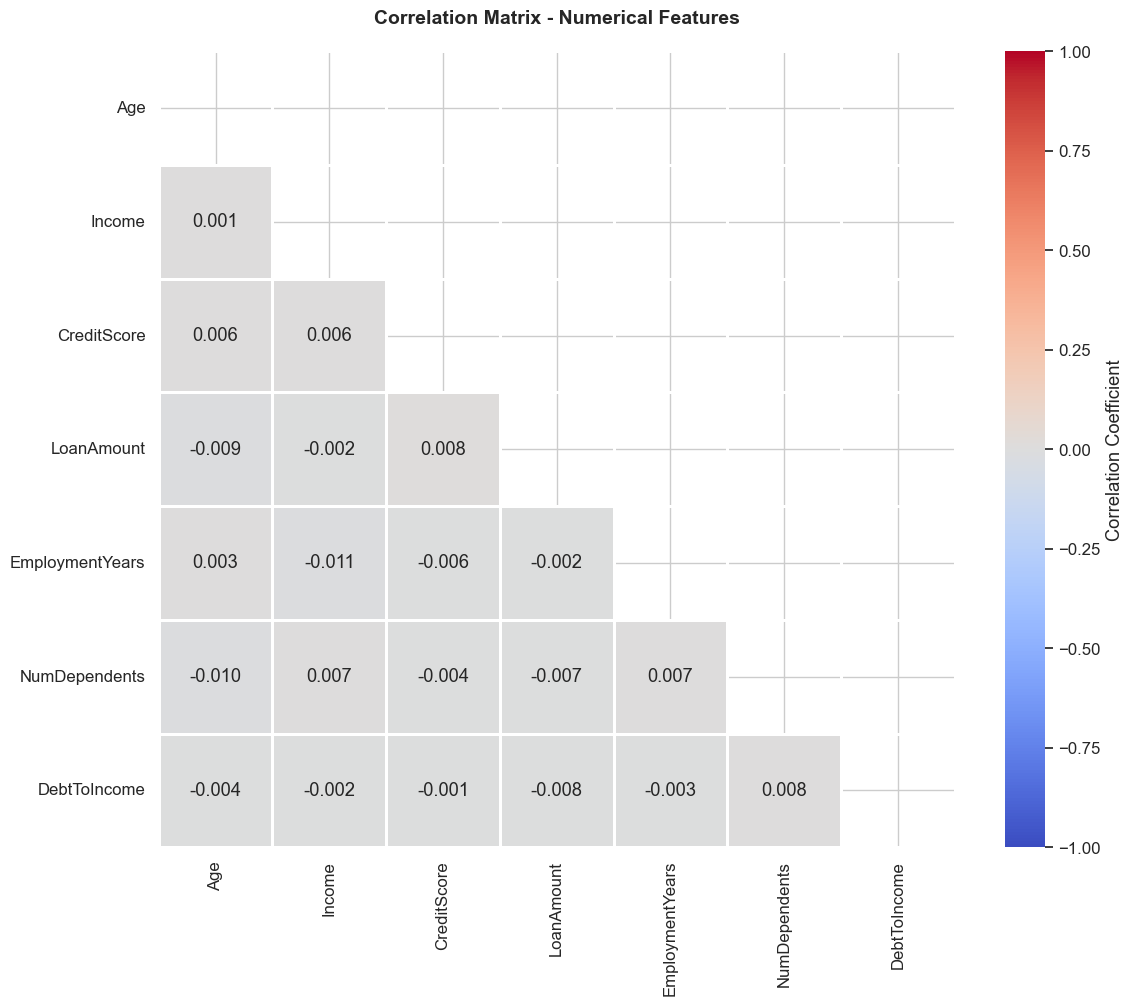

Figure saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/figures/07_correlation_heatmap.png


In [64]:
# correlation heatmap
fig, ax = plt.subplots(figsize=(12, 10))

# mask for upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# heatmap with seaborn
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            fmt='.3f',
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={'label': 'Correlation Coefficient'},
            vmin=-1, vmax=1,
            ax=ax)

ax.set_title('Correlation Matrix - Numerical Features', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '07_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to {FIGURES_DIR / '07_correlation_heatmap.png'}")

<Figure size 1800x1800 with 0 Axes>

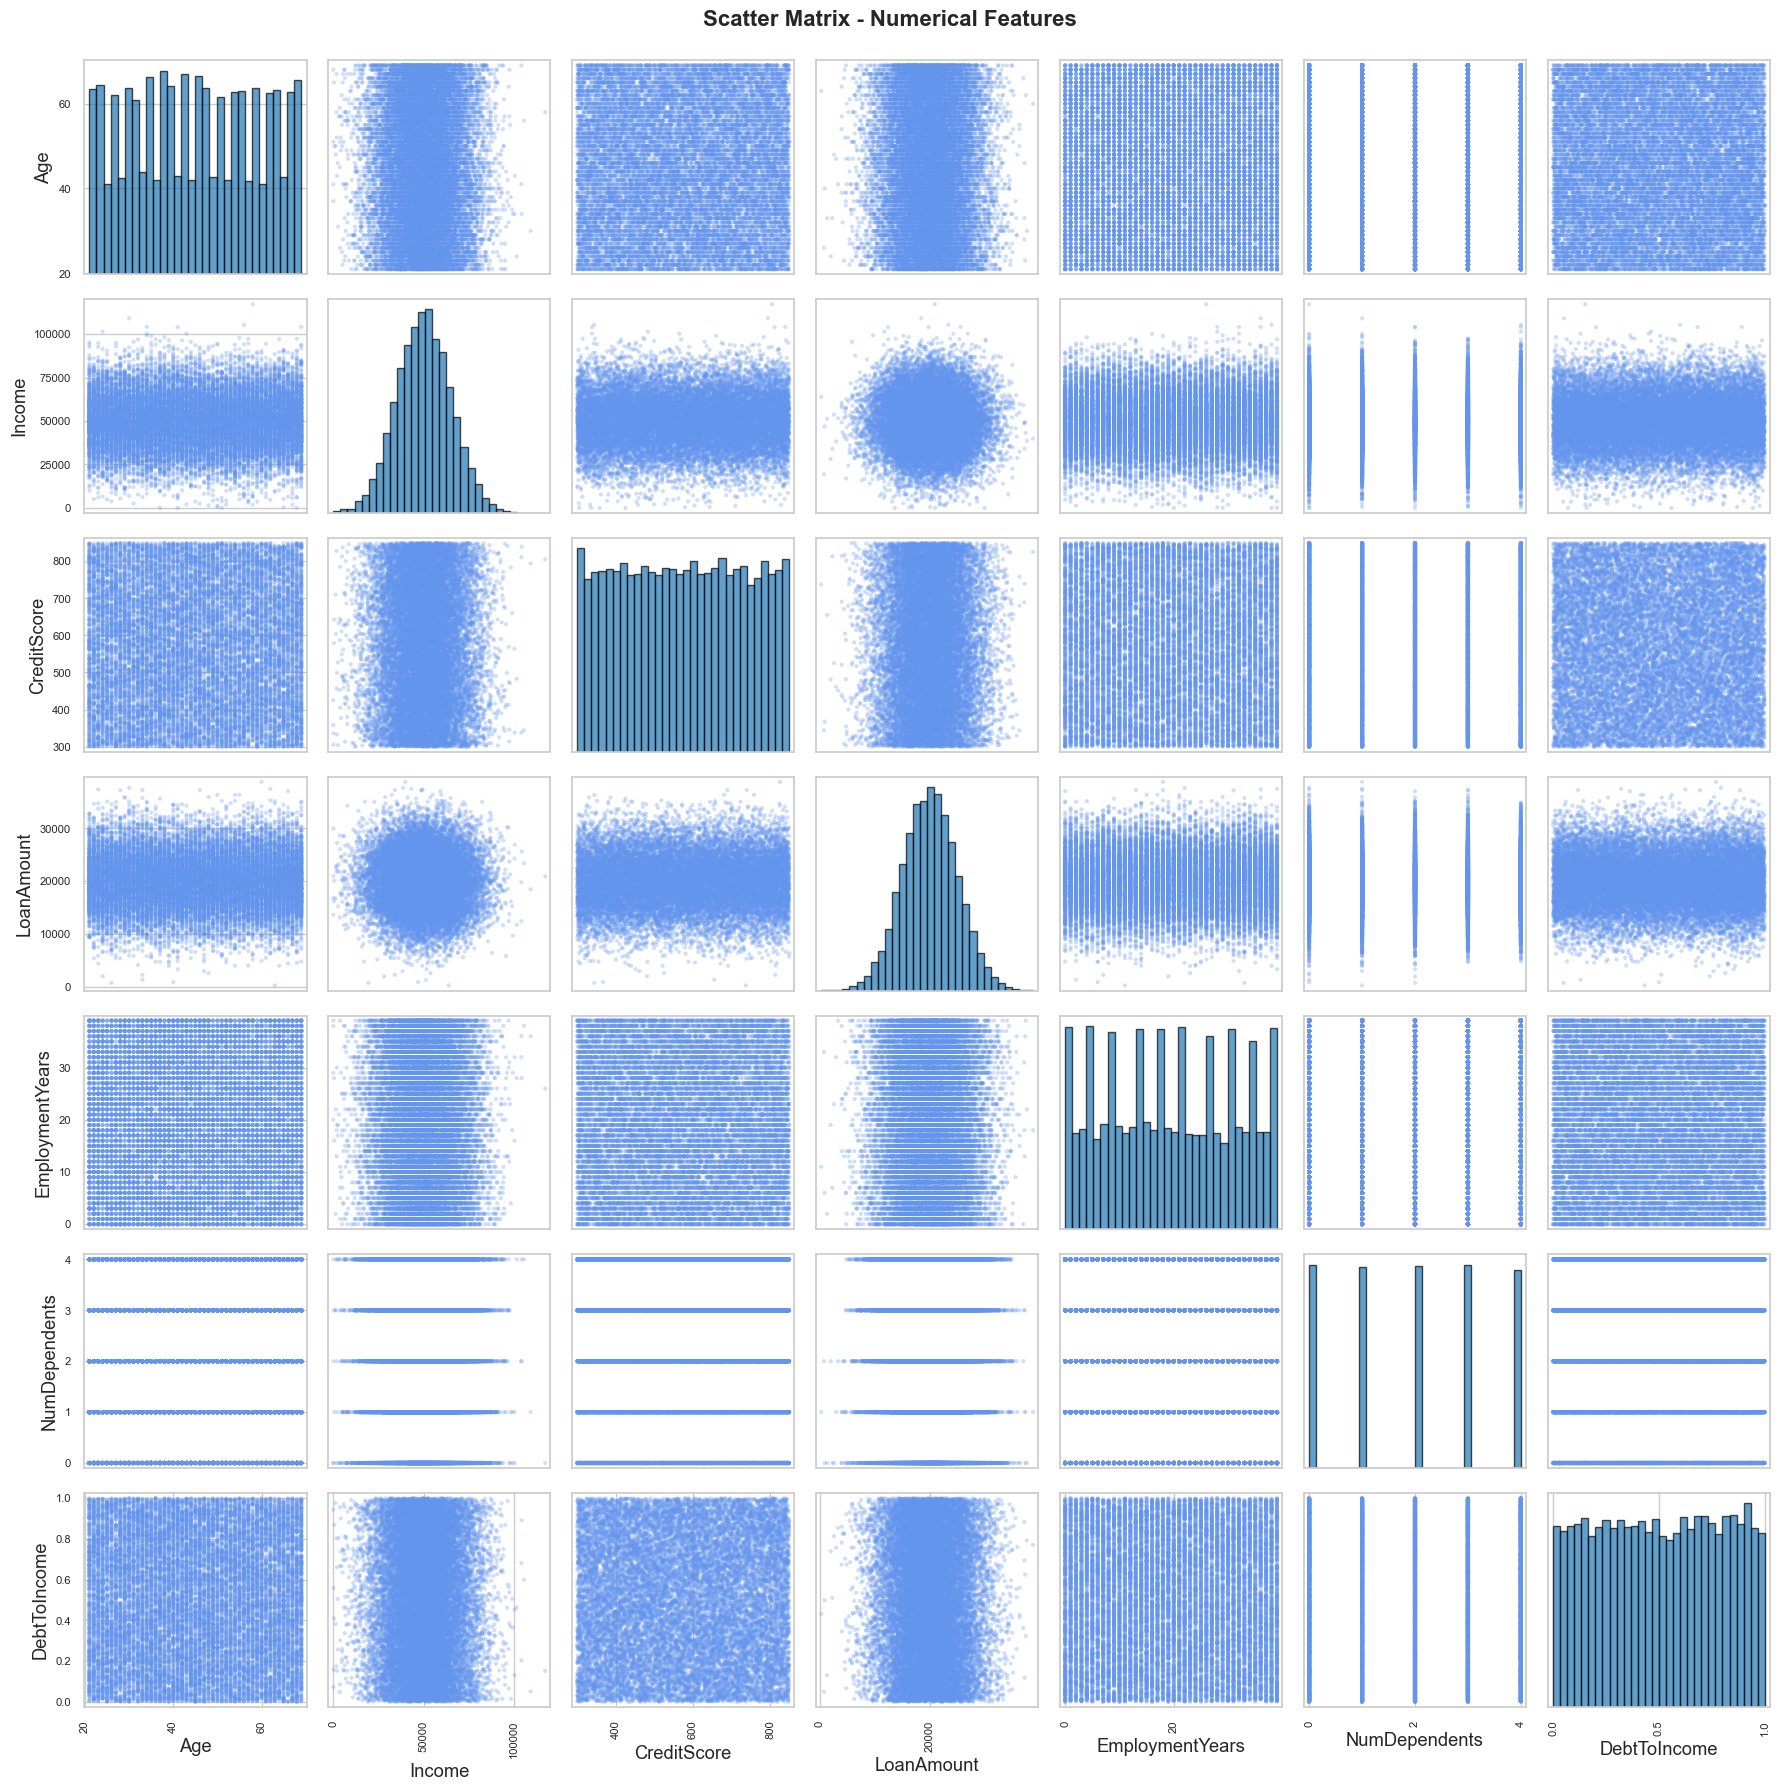

Figure saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/figures/09_scatter_matrix.png

This shows all pairwise relationships between numerical features.
Diagonal shows distribution of each feature.
Off-diagonal shows scatter plots between feature pairs.


In [78]:
from pandas.plotting import scatter_matrix

fig = plt.figure(figsize=(18, 18))
scatter_matrix(train_df[NUMERICAL_FEATURES], alpha=0.3, figsize=(18, 18), 
               diagonal='hist', color=Color.BLUE.value, 
               hist_kwds={'bins': 30, 'edgecolor': Color.BLACK.value, 'alpha': 0.7})

plt.suptitle('Scatter Matrix - Numerical Features', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '09_scatter_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to {FIGURES_DIR / '09_scatter_matrix.png'}")
print("\nThis shows all pairwise relationships between numerical features.")
print("Diagonal shows distribution of each feature.")
print("Off-diagonal shows scatter plots between feature pairs.")

In [69]:
print("=" * 80)
print("CATEGORICAL FEATURES - MISSING VALUE ANALYSIS")
print("=" * 80)

for feature in CATEGORICAL_FEATURES:
    train_missing = train_df[feature].isnull().sum()
    train_missing_pct = (train_missing / len(train_df)) * 100
    
    test_missing = test_df[feature].isnull().sum()
    test_missing_pct = (test_missing / len(test_df)) * 100
    
    print(f"\n{feature}:")
    print(f"  Training set: {train_missing:,} missing ({train_missing_pct:.2f}%)")
    print(f"  Test set: {test_missing:,} missing ({test_missing_pct:.2f}%)")
    
    if train_missing > 0:
        # analyze if missingness correlates with default
        has_value = ~train_df[feature].isnull()
        default_rate_with_value = train_df[has_value][TARGET_FEATURE].mean() * 100
        default_rate_missing = train_df[~has_value][TARGET_FEATURE].mean() * 100
        
        print(f"  Default rate when present: {default_rate_with_value:.2f}%")
        print(f"  Default rate when missing: {default_rate_missing:.2f}%")
        print(f"  Difference: {abs(default_rate_with_value - default_rate_missing):.2f}pp")
        
        # Chi-square test
        contingency = pd.crosstab(train_df[feature].isnull(), train_df[TARGET_FEATURE])
        chi2, p_value, dof, expected = chi2_contingency(contingency)
        print(f"  Chi-square p-value: {p_value:.6f}")
        
        if p_value < 0.05:
            print(f"  Conclusion: Missingness IS significant - create indicator feature")
        else:
            print(f"  Conclusion: Missingness is NOT significant")
    else:
        print(f"  No missing values - 'has/doesn't have' analysis not applicable")

CATEGORICAL FEATURES - MISSING VALUE ANALYSIS

FavoriteColor:
  Training set: 0 missing (0.00%)
  Test set: 0 missing (0.00%)
  No missing values - 'has/doesn't have' analysis not applicable

Hobby:
  Training set: 0 missing (0.00%)
  Test set: 0 missing (0.00%)
  No missing values - 'has/doesn't have' analysis not applicable


In [84]:
print("=" * 80)
print("CATEGORICAL FEATURES ANALYSIS")
print("=" * 80)

for feature in CATEGORICAL_FEATURES:
    print(f"\n{feature}:")
    print("-" * 40)
    
    # overall distribution
    value_counts = train_df[feature].value_counts()
    value_pct = train_df[feature].value_counts(normalize=True) * 100
    
    print("\nOverall distribution:")
    for category in value_counts.index:
        count = value_counts[category]
        pct = value_pct[category]
        print(f"  {category:12s}: {count:5,} ({pct:5.2f}%)")
    
    # dist by default status
    print("\nDefault rate by category:")
    default_by_category = train_df.groupby(feature)[TARGET_FEATURE].agg([
        ('Total', 'count'),
        ('Defaults', 'sum'),
        ('Default_Rate', 'mean')
    ])
    default_by_category['Default_Rate_Pct'] = (default_by_category['Default_Rate'] * 100).round(2)
    
    for category in default_by_category.index:
        total = default_by_category.loc[category, 'Total']
        defaults = int(default_by_category.loc[category, 'Defaults'])
        rate = default_by_category.loc[category, 'Default_Rate_Pct']
        print(f"  {category:12s}: {defaults:4,}/{total:5,} ({rate:5.2f}%)")
    
    # Chi-square test
    contingency_table = pd.crosstab(train_df[feature], train_df[TARGET_FEATURE])
    display(contingency_table)
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\nChi-square test of independence:")
    print(f"  Chi-square statistic: {chi2:.4f}")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Degrees of freedom: {dof}")
    
    if p_value < 0.05:
        print(f"  Result: SIGNIFICANT (p < 0.05)")
        print(f"  Conclusion: {feature} shows relationship with default status")
    else:
        print(f"  Result: NOT significant (p >= 0.05)")
        print(f"  Conclusion: {feature} appears independent of default status")



CATEGORICAL FEATURES ANALYSIS

FavoriteColor:
----------------------------------------

Overall distribution:
  Red         : 5,096 (25.48%)
  Yellow      : 4,992 (24.96%)
  Green       : 4,969 (24.84%)
  Blue        : 4,943 (24.71%)

Default rate by category:
  Blue        : 1,701/4,943 (34.41%)
  Green       : 1,725/4,969 (34.72%)
  Red         : 1,732/5,096 (33.99%)
  Yellow      : 1,705/4,992 (34.15%)


Default,0,1
FavoriteColor,,
Blue,3242,1701
Green,3244,1725
Red,3364,1732
Yellow,3287,1705



Chi-square test of independence:
  Chi-square statistic: 0.6734
  p-value: 0.879435
  Degrees of freedom: 3
  Result: NOT significant (p >= 0.05)
  Conclusion: FavoriteColor appears independent of default status

Hobby:
----------------------------------------

Overall distribution:
  Gaming      : 5,116 (25.58%)
  Traveling   : 5,074 (25.37%)
  Reading     : 4,915 (24.57%)
  Sports      : 4,895 (24.47%)

Default rate by category:
  Gaming      : 1,753/5,116 (34.27%)
  Reading     : 1,653/4,915 (33.63%)
  Sports      : 1,690/4,895 (34.53%)
  Traveling   : 1,767/5,074 (34.82%)


Default,0,1
Hobby,,
Gaming,3363,1753
Reading,3262,1653
Sports,3205,1690
Traveling,3307,1767



Chi-square test of independence:
  Chi-square statistic: 1.7040
  p-value: 0.636035
  Degrees of freedom: 3
  Result: NOT significant (p >= 0.05)
  Conclusion: Hobby appears independent of default status


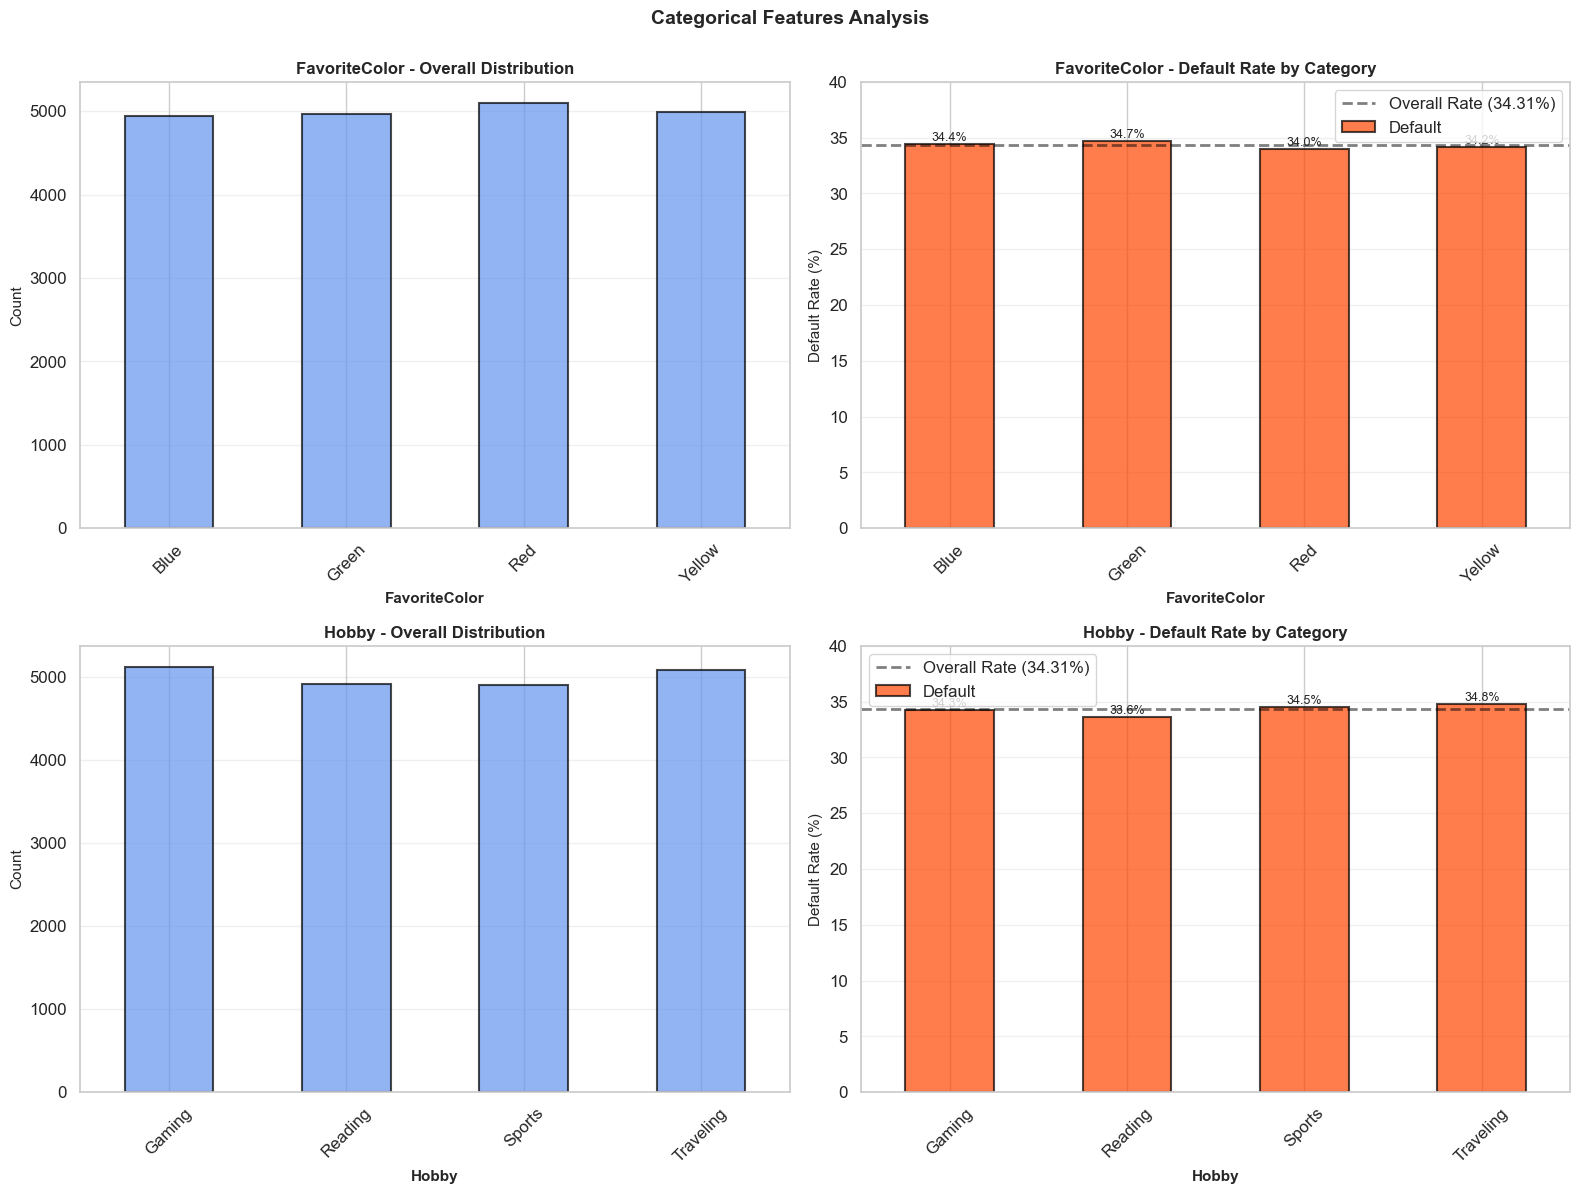

✓ Figure saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/figures/05_categorical_distributions.png


In [66]:
# bar charts showing categorical feature distributions by default status
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, feature in enumerate(CATEGORICAL_FEATURES):
    # Panel 1: Overall distribution
    ax1 = axes[idx, 0]
    value_counts = train_df[feature].value_counts().sort_index()
    value_counts.plot(kind='bar', ax=ax1, color=Color.BLUE.value, alpha=0.7, 
                      edgecolor=Color.BLACK.value, linewidth=1.5)
    ax1.set_title(f'{feature} - Overall Distribution', fontsize=12, fontweight='bold')
    ax1.set_xlabel(feature, fontsize=11, fontweight='bold')
    ax1.set_ylabel('Count', fontsize=11)
    ax1.grid(axis='y', alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Panel 2: Default rate by category
    ax2 = axes[idx, 1]
    default_by_category = train_df.groupby(feature)[TARGET_FEATURE].mean() * 100
    default_by_category = default_by_category.sort_index()
    
    bars = default_by_category.plot(kind='bar', ax=ax2, color=Color.RED.value, alpha=0.7,
                                     edgecolor=Color.BLACK.value, linewidth=1.5)
    
    # Add overall default rate as reference line
    overall_rate = train_df[TARGET_FEATURE].mean() * 100
    ax2.axhline(y=overall_rate, color=Color.BLACK.value, linestyle='--', 
                linewidth=2, label=f'Overall Rate ({overall_rate:.2f}%)', alpha=0.5)
    
    ax2.set_title(f'{feature} - Default Rate by Category', fontsize=12, fontweight='bold')
    ax2.set_xlabel(feature, fontsize=11, fontweight='bold')
    ax2.set_ylabel('Default Rate (%)', fontsize=11)
    ax2.set_ylim([0, max(40, default_by_category.max() + 5)])
    ax2.grid(axis='y', alpha=0.3)
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    
    # Add percentage labels on bars
    for bar in ax2.patches:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

plt.suptitle('Categorical Features Analysis', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '05_categorical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to {FIGURES_DIR / '05_categorical_distributions.png'}")